In [1]:
#데이터 수집 및 전처리

In [7]:

#******보완사항******
#저장된 stft데이터를 csv파일로 제작

#필요사항 import
import numpy as np
import pandas as pd
import librosa
import scipy.io.wavfile


#오디오 데이터를 stft처리하는 함수
def load_data(file_path, sr=44100, duration=10):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    stft_data = librosa.stft(audio)
    return stft_data

#stft데이터를 csv파일로 변환하는 함수
def create_csv_from_stft(stft_data, output_csv_path, split_duration=0.1):
    num_splits = stft_data.shape[1]

    data_list = []
    for i in range(num_splits):
        magnitude = np.abs(stft_data[:, i])
        phase = np.angle(stft_data[:, i])
        time = i * split_duration
        data_list.append([time] + magnitude.tolist() + phase.tolist())
        
        
    columns = ["time"] + [f"magnitude_{i}" for i in range(magnitude.shape[0])] + [f"phase_{i}" for i in range(phase.shape[0])]
    df = pd.DataFrame(data_list, columns=columns)
    df.to_csv(output_csv_path, index=False)

#인풋 파일 경로와 출력 CSV 파일 경로를 지정
input_external_file = 'out_noise70dB_iphone12mini.wav'
input_internal_file = 'in_noise50dB_iphone12mini.wav'
external_csv = 'external_noise_stft.csv'
internal_csv = 'internal_noise_stft.csv'

# 데이터 로드 및 STFT 분석을 수행
external_noise_data = load_data(input_external_file)
internal_noise_data = load_data(input_internal_file)

# STFT 데이터를 CSV 파일로 저장 수행
create_csv_from_stft(external_noise_data, external_csv)
create_csv_from_stft(internal_noise_data, internal_csv)

#저장한 csv파일을 코드에 사용 가능하도록 불러오기
external_usable=pd.read_csv("external_noise_stft.csv")
internal_usable=pd.read_csv("internal_noise_stft.csv")

In [9]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16931867301449074338
 xla_global_id: -1]

In [3]:
#LSTM 모델 구축

In [4]:
#시각화 및 데이터 전처리 도구 IMPORT

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

#딥러닝 모델 제작 툴 라이브러리 IMPORT

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import *

#LSTM 라이브러리 IMPORT

from keras.layers import LSTM

#세부사항 라이브러리 IMPORT

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [5]:
# Feature를 Scaling

sc = MinMaxScaler(feature_range = (0, 1))

external_noise_data_scaled = sc.fit_transform(external_usable)


In [6]:


#LSTM 모델 제작

model = Sequential()

#첫번째 LSTM layer 추가

model.add(LSTM(units = 50, return_sequences = True, input_shape = (external_usable.shape[1], 1),activation='tanh'))

model.add(Dropout(0.2))  #20퍼센트의 뉴런을 off 한다( 오버피팅을 막기 위해)

#두번째 LSTM layer 추가

model.add(LSTM(units = 50, return_sequences = True,activation='tanh'))

model.add(Dropout(0.2))  #20퍼센트의 뉴런을 off 한다( 오버피팅을 막기 위해)

#세번째 LSTM layer 추가

model.add(LSTM(units = 50, return_sequences = True,activation='tanh'))

model.add(Dropout(0.2))  #20퍼센트의 뉴런을 off 한다( 오버피팅을 막기 위해)

#네번째 LSTM layer 추가

model.add(LSTM(units = 50))

model.add(Dropout(0.2))  #20퍼센트의 뉴런을 off 한다( 오버피팅을 막기 위해)

#output layer 설정

model.add(Dense(units = 1))

#RNN 컴파일링

model.compile(optimizer='adam',loss='mean_squared_error')


#모델 적용 및 훈련 시작

model.fit(external_noise_data_scaled, internal_usable, epochs = 10, batch_size = 32)


Epoch 1/10
27/27 [==============================] - 217s 7s/step - loss: 2.8545
Epoch 2/10
27/27 [==============================] - 195s 7s/step - loss: 2.8541
Epoch 3/10
13/27 [=============>................] - ETA: 1:38 - loss: 2.8641

KeyboardInterrupt: 

In [7]:
#예측 모델 생성 및 학습
#학습은 이미 완료된 모델을 사용하므로 또 필요 X

anc_model = model

def apply_anc(external_noise_data_scaled, anc_model):
    predicted_internal_noise = anc_model.predict(external_noise_data_scaled)
    return predicted_internal_noise

predicted_internal_noise = apply_anc(external_noise_data_scaled, anc_model)



10/10 [==============================] - 18s 1s/step


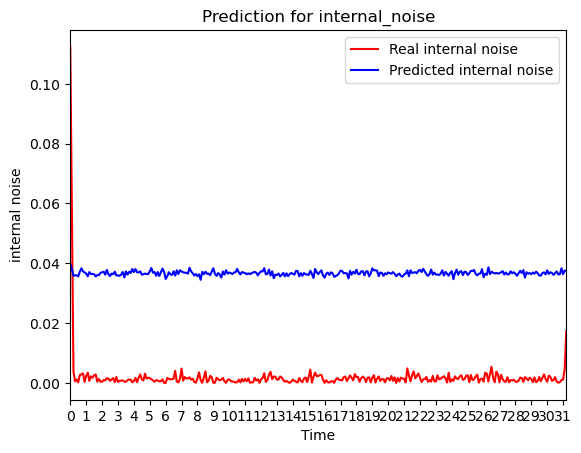

In [9]:
# 예측된 내부 소음과 실제 내부 소음을 비교(시각화)


#시각화

plt.plot(internal_usable['time'],internal_usable['magnitude_0'], color = 'red', label = 'Real internal noise')

plt.plot(internal_usable['time'],predicted_internal_noise[:,0], color = 'blue', label = 'Predicted internal noise')

plt.xticks(np.arange(0,len(internal_usable),1))

plt.xlim(internal_usable['time'].min(), internal_usable['time'].max())

plt.title('Prediction for internal_noise')

plt.xlabel('Time')

plt.ylabel('internal noise')

plt.legend()

plt.show()


In [22]:

import soundfile as sf

# ISTFT 변환
def istft(stft_matrix):
    return librosa.istft(stft_matrix)

# 예측된 내부 소음의 magnitude 정보 가져오기
predicted_magnitude = predicted_internal_noise

# 예측된 내부 소음의 magnitude 정보를 기반으로 STFT 데이터 생성
predicted_stft_data = np.zeros((predicted_magnitude.shape[0], predicted_magnitude.shape[1]), dtype=np.complex128)
for i in range(predicted_magnitude.shape[1]):
    magnitude = predicted_magnitude[:, i]
    
    # 마지막 열에 저장된 phase 정보 가져오기
    phase = internal_usable.iloc[i, -predicted_magnitude.shape[0]:].values
    
    complex_data = magnitude * np.exp(1j * phase)
    predicted_stft_data[:, i] = complex_data

    
# 예측 내부 소음의 역위상을 시간 도메인 신호로 변환
anc_audio = istft(predicted_stft_data)

# 결과 저장
sf.write('anc_audio.wav', anc_audio, 44100)